# ¿Quién tiene más probabilidades de marcharse?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyodbc
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv("aug_train.csv")

# 1 Entender el Dataset

In [3]:
df.dtypes #compruebo de que tipo es cada columna, para poder jugar con ellas correctamente

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [4]:
#Descubrir valores únicos y nulos
unique_values = df.nunique()
missing_values = df.isnull().sum()

# Crear resumen combinado
summary = pd.DataFrame({
    "Valores únicos": unique_values,
    "Valores nulos": missing_values,
    "Porcentaje nulos (%)": (missing_values / len(df) * 100).round(2)
})

# Visualizar resumen
print(summary)

                        Valores únicos  Valores nulos  Porcentaje nulos (%)
enrollee_id                      19158              0                  0.00
city                               123              0                  0.00
city_development_index              93              0                  0.00
gender                               3           4508                 23.53
relevent_experience                  2              0                  0.00
enrolled_university                  3            386                  2.01
education_level                      5            460                  2.40
major_discipline                     6           2813                 14.68
experience                          22             65                  0.34
company_size                         8           5938                 30.99
company_type                         6           6140                 32.05
last_new_job                         6            423                  2.21
training_hou

In [5]:
# quiero saber cuales son las opciones en cada columna (actualizo tras categorización NaN)
df["gender"].value_counts()

gender
Male      13221
Female     1238
Other       191
Name: count, dtype: int64

In [7]:
df["relevent_experience"].value_counts()

relevent_experience
Has relevent experience    13792
No relevent experience      5366
Name: count, dtype: int64

In [8]:
df["enrolled_university"].value_counts()

enrolled_university
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: count, dtype: int64

In [9]:
df["education_level"].value_counts()

education_level
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: count, dtype: int64

In [10]:
df["major_discipline"].value_counts() #reduzco a non-stem y stem

major_discipline
STEM               14492
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: count, dtype: int64

In [10]:
df["experience"].value_counts() #habrá que editar el <1 a 0

experience
>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: count, dtype: int64

In [11]:
df["company_size"].value_counts() #habrá que editarlos a numero medio del rango

company_size
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: count, dtype: int64

In [12]:
df["company_type"].value_counts()

company_type
Pvt Ltd                9817
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: count, dtype: int64

In [13]:
df["last_new_job"].value_counts() #hay que cambiarlo

last_new_job
1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: count, dtype: int64

# 2 Limpiar el Dataset

In [3]:
#Quiero ver cuantas filas hay con valores nulos excesivos
umbral = 0.4  # 40%
filas_con_muchos_nulos = df.isnull().mean(axis=1) > umbral
df[filas_con_muchos_nulos]  # ← Esto muestra cuáles son esas filas

#voy a eliminar 6 filas que tienen 40% de valores nulos, y no me van a aportar nada en mi estudio
df = df.loc[~filas_con_muchos_nulos]

In [4]:
#Voy a eliminar los nulos de enrolled university, education_level, experience y last_new_job porque el porcentaje es mínimo
df = df.dropna(subset=["last_new_job"])
df = df.dropna(subset=["experience"])
df = df.dropna(subset=["education_level"])
df = df.dropna(subset=["enrolled_university"])

In [5]:
#Ahora me queda gender, major_discipline, company_size y company_type con nulos, rellenar con el modo puede introducir sesgo. La ausencia también es información.
df["gender"] = df["gender"].fillna("Unknown")
df["major_discipline"] = df["major_discipline"].fillna("No Info")
df["company_size"] = df["company_size"].fillna("Unknown")
df["company_type"] = df["company_type"].fillna("Unknown")

#Ya tengo 0 nulos

In [6]:
#Ahora vamos a por los valores únicos y su estandarización
#Reducimos major_discipline a STEM y No STEM
# Primero, creamos un mapeo
df['major_discipline'] = df['major_discipline'].replace({
    'STEM': 'STEM',
    'Humanities': 'non-STEM',
    'Other': 'non-STEM',
    'Business Degree': 'non-STEM',
    'No Major': 'non-STEM',
    'Arts': 'non-STEM'
})

# Confirmamos los nuevos valores
print(df['major_discipline'].value_counts())


major_discipline
STEM        13993
No Info      2222
non-STEM     1799
Name: count, dtype: int64


In [7]:
#elimino >20 y <1 y lo cambio a 21 y 0
def experience(val):
    if val == '>20':
        return 21
    elif val == '<1':
        return 0
    else:
        return int(val)
        
df['experience'] = df['experience'].apply(experience)

In [8]:
#cambio valores a un punto medio del rango
def company_size(val):
    if val == '<10':
        return 5
    elif val == '10/49':
        return 30
    elif val == '50-99':
        return 75
    elif val == '100-500':
        return 300
    elif val == '500-999':
        return 750
    elif val == '1000-4999':
        return 3000
    elif val == '5000-9999':
        return 7500
    elif val == '10000+':
        return 10000
    else:
        return 0 

df['company_size'] = df['company_size'].apply(company_size)
# Verificar
df['company_size'].value_counts()

company_size
0        5310
75       2950
300      2483
10000    1964
30       1394
3000     1282
5        1242
750       847
7500      542
Name: count, dtype: int64

In [9]:
#ultima columna por limpiar
def last_new_job(val):
    if val == 'never':
        return 0
    elif val == '>4':
        return 5
    else:
        return int(val)

df['last_new_job'] = df['last_new_job'].apply(last_new_job)

# Verificar
df['last_new_job'].value_counts()

last_new_job
1    7789
5    3210
2    2827
0    2187
4    1010
3     991
Name: count, dtype: int64

In [10]:
df = df.drop(columns=['city']) #elimino columna tras darme problema en VIF, multicolinealidad

In [22]:
#Descubrir valores únicos y nulos
unique_values = df.nunique()
missing_values = df.isnull().sum()

# Crear resumen combinado
summary = pd.DataFrame({
    "Valores únicos": unique_values,
    "Valores nulos": missing_values,
    "Porcentaje nulos (%)": (missing_values / len(df) * 100).round(2)
})

# Visualizar resumen
print(summary)

                        Valores únicos  Valores nulos  Porcentaje nulos (%)
enrollee_id                      18014              0                   0.0
city_development_index              93              0                   0.0
gender                               4              0                   0.0
relevent_experience                  2              0                   0.0
enrolled_university                  3              0                   0.0
education_level                      5              0                   0.0
major_discipline                     3              0                   0.0
experience                          22              0                   0.0
company_size                         9              0                   0.0
company_type                         7              0                   0.0
last_new_job                         6              0                   0.0
training_hours                     241              0                   0.0
target      

# Analisis Exploratorio

In [22]:
df.describe()

,enrollee_id,city_development_index,experience,company_size,last_new_job,training_hours,target
count,18014.000000,18014.000000,18014.000000,18014.000000,18014.000000,18014.000000,18014.000000
mean,16903.699734,0.831728,10.282447,1620.985345,2.026535,65.347896,0.245420
std,9665.557267,0.122115,6.760575,3263.190229,1.673468,60.059220,0.430348
min,1.000000,0.448000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,8528.750000,0.745000,5.000000,0.000000,1.000000,23.000000,0.000000
50%,17012.500000,0.910000,9.000000,75.000000,1.000000,47.000000,0.000000
75%,25326.250000,0.920000,16.000000,750.000000,3.000000,88.000000,0.000000
max,33380.000000,0.949000,21.000000,10000.000000,5.000000,336.000000,1.000000


<function matplotlib.pyplot.show(close=None, block=None)>

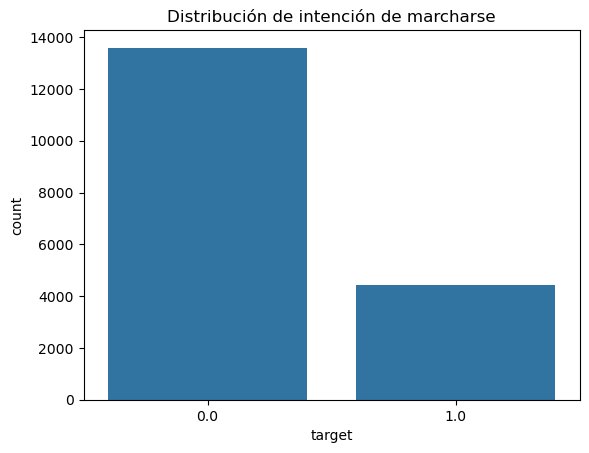

In [23]:
#distribucion marcharse del trabajo
sns.countplot(data=df, x="target")
plt.title("Distribución de intención de marcharse")
plt.show

#1 = los que se quieren ir

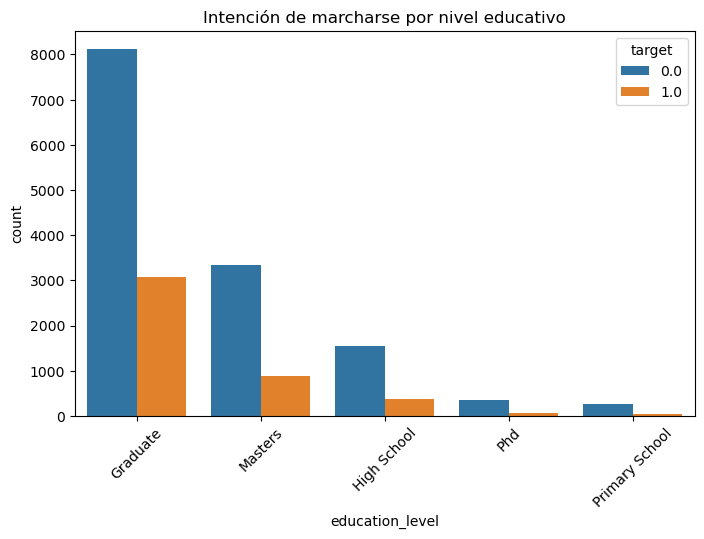

In [24]:
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="education_level", hue="target")
plt.title("Intención de marcharse por nivel educativo")
plt.xticks(rotation=45)
plt.show()

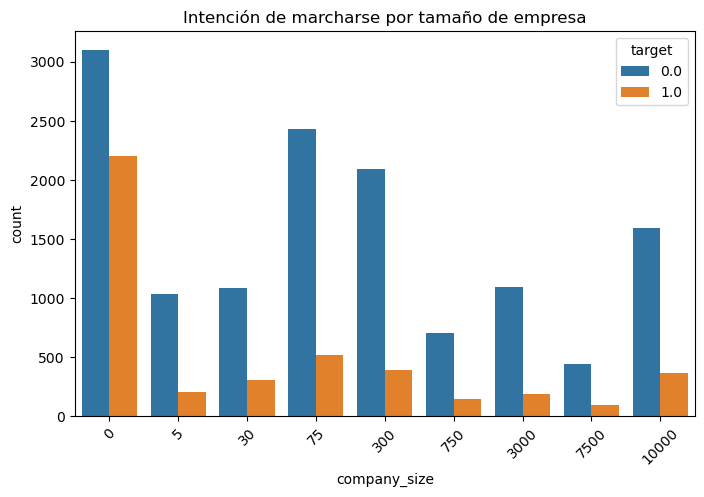

In [25]:
# Company size vs target
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="company_size", hue="target")
plt.title("Intención de marcharse por tamaño de empresa")
plt.xticks(rotation=45)
plt.show()

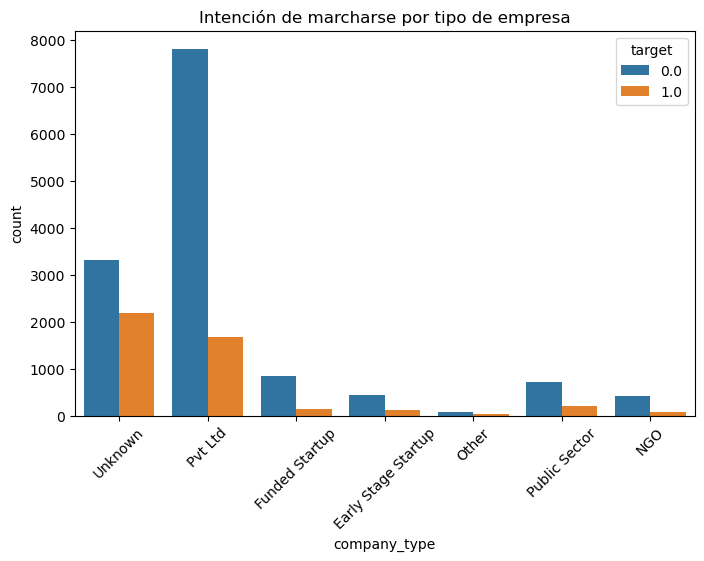

In [26]:
# Company type vs target
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="company_type", hue="target")
plt.title("Intención de marcharse por tipo de empresa")
plt.xticks(rotation=45)
plt.show()

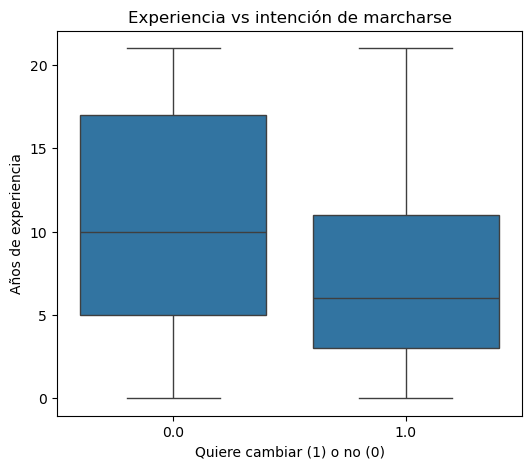

In [27]:
# Experiencia vs target (Boxplot)
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="target", y="experience")
plt.title("Experiencia vs intención de marcharse")
plt.xlabel("Quiere cambiar (1) o no (0)")
plt.ylabel("Años de experiencia")
plt.show()

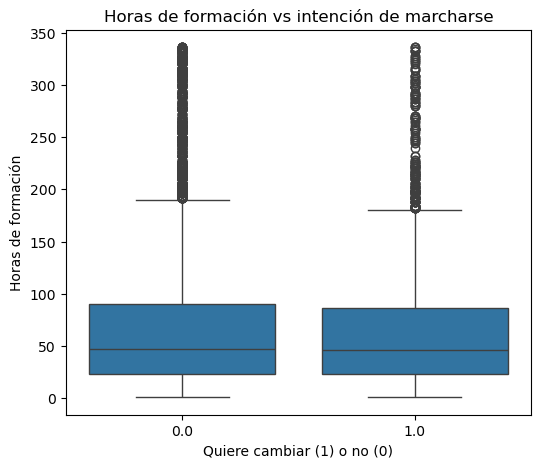

In [28]:
# Training hours vs target (Boxplot)
plt.figure(figsize=(6,5))
sns.boxplot(data=df, x="target", y="training_hours")
plt.title("Horas de formación vs intención de marcharse")
plt.xlabel("Quiere cambiar (1) o no (0)")
plt.ylabel("Horas de formación")
plt.show()

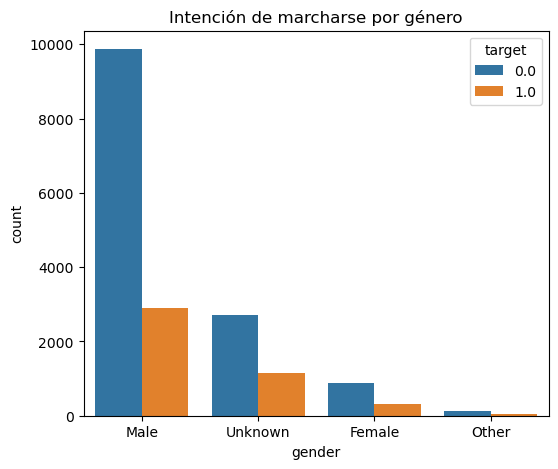

In [29]:
# Género vs target
plt.figure(figsize=(6,5))
sns.countplot(data=df, x="gender", hue="target")
plt.title("Intención de marcharse por género")
plt.show()


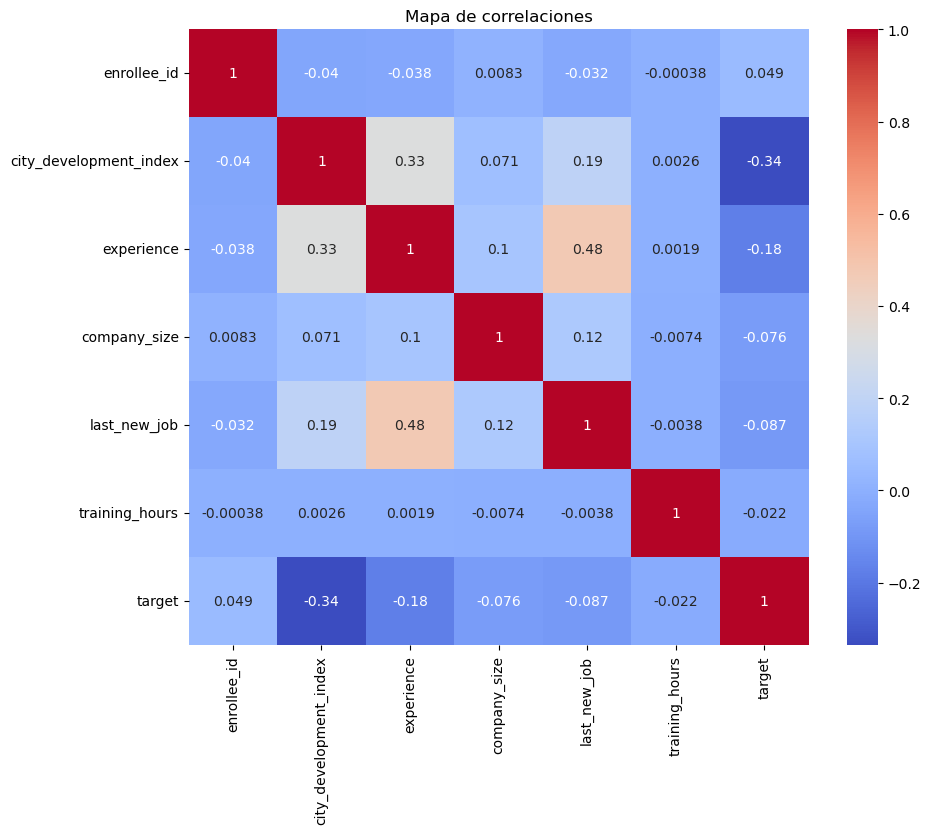

'\nmayor relacion entre target y:\ncity_development_index (negativa, a más desarrollo, menos probabilidad)\nexperience (más experiencia, menos probabilidad)\nlast_new_job (si cambió hace poco, menos probabilidad)\ntraining_hours (no afecta)\ncompany_size (no afecta)\n'

In [30]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Mapa de correlaciones')
plt.show()

'''
mayor relacion entre target y:
city_development_index (negativa, a más desarrollo, menos probabilidad)
experience (más experiencia, menos probabilidad)
last_new_job (si cambió hace poco, menos probabilidad)
training_hours (no afecta)
company_size (no afecta)
'''


# Análisis Predictivo

In [11]:
# Eliminamos columnas que no sirven o irrelevantes
X = df.drop(['target', 'enrollee_id'], axis=1)
y = df['target']

In [12]:
categorical_cols = X.select_dtypes(include='object').columns
print(categorical_cols)

Index(['gender', 'relevent_experience', 'enrolled_university',
       'education_level', 'major_discipline', 'company_type'],
      dtype='object')


In [13]:
# Seleccionar solo columnas categóricas
categorical_cols = X.select_dtypes(include=['object']).columns

# One-Hot Encoding (crea columnas dummies)
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)


In [14]:
# Convertir todos los bool a int (0 y 1)
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif_data = pd.DataFrame()
vif_data["feature"] = X_encoded.columns
vif_data["VIF"] = [variance_inflation_factor(X_encoded.values, i)
                   for i in range(X_encoded.shape[1])]

vif_data[vif_data["VIF"] > 5]

#decido eliminar variable city, no la voy a utilizar y no aporta nada

,feature,VIF
0,city_development_index,53.332471
1,experience,5.406166
5,gender_Male,11.616568
10,enrolled_university_no_enrollment,6.429566
11,education_level_High School,10.668443
15,major_discipline_STEM,67.924522
16,major_discipline_non-STEM,10.087794
21,company_type_Pvt Ltd,17.780828
22,company_type_Unknown,10.699595


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    train_size = 0.75,
    test_size = 0.25
)

### Modelo Random-Forest

In [56]:
clf = RandomForestClassifier(max_depth=10)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [57]:
accuracy_score(y_test, y_pred)

0.7921847246891652

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_prob = clf.predict_proba(X_test)[:,1]
print("ROC AUC:", roc_auc_score(y_test, y_prob))

[[3062  363]
 [ 573  506]]
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.87      3425
         1.0       0.58      0.47      0.52      1079

    accuracy                           0.79      4504
   macro avg       0.71      0.68      0.69      4504
weighted avg       0.78      0.79      0.78      4504

ROC AUC: 0.8046479911786393


### Modelo Regresión Logística

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)


In [18]:
#regresion logistica
clf_log = LogisticRegression(
    max_iter=1000,
    class_weight='balanced', #por tener la muestra muy desigual
    random_state=42
)

clf_log.fit(x_train_scaled, y_train)

# -------------------------------
# Evaluación
# -------------------------------
y_pred = clf_log.predict(x_test_scaled)
y_prob = clf_log.predict_proba(x_test_scaled)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

[[2424 1017]
 [ 281  782]]
              precision    recall  f1-score   support

         0.0       0.90      0.70      0.79      3441
         1.0       0.43      0.74      0.55      1063

    accuracy                           0.71      4504
   macro avg       0.67      0.72      0.67      4504
weighted avg       0.79      0.71      0.73      4504

ROC AUC: 0.7693459398766959


## Reducción de variables y nuevo modelo

## Se reeduce capacidad predictiva del modelo
      precision    recall  f1-score   support

         0.0       0.87      0.72      0.79      3402
         1.0       0.44      0.66      0.53      1102

    accuracy                           0.71      4504
   macro avg       0.65      0.69      0.66      4504
weighted avg       0.76      0.71      0.72      4504

ROC AUC: 0.7250453720508168

In [88]:
df_v2 = df.copy()

In [98]:
df_v2 = df_v2.drop(columns=['major_discipline', 'company_type','gender']) #elimino varias columnas tras darme problema en VIF, multicolinealidad, se redujo la capacidad predictiva del modelo

KeyError: "['major_discipline', 'company_type', 'gender'] not found in axis"

In [90]:
X_v2 = df_v2.drop(["target",'enrollee_id'], axis=1)
y_v2 = df_v2["target"]

In [91]:
X_v2

,city_development_index,relevent_experience,enrolled_university,education_level,experience,company_size,last_new_job,training_hours
0,0.920,Has relevent experience,no_enrollment,Graduate,21,0,1,36
1,0.776,No relevent experience,no_enrollment,Graduate,15,75,5,47
2,0.624,No relevent experience,Full time course,Graduate,5,0,0,83
4,0.767,Has relevent experience,no_enrollment,Masters,21,75,4,8
5,0.764,Has relevent experience,Part time course,Graduate,11,0,1,24
...,...,...,...,...,...,...,...,...
19153,0.878,No relevent experience,no_enrollment,Graduate,14,0,1,42
19154,0.920,Has relevent experience,no_enrollment,Graduate,14,0,4,52
19155,0.920,Has relevent experience,no_enrollment,Graduate,21,75,4,44
19156,0.802,Has relevent experience,no_enrollment,High School,0,750,2,97


In [92]:
# Codificación
X_encoded_v2 = pd.get_dummies(X_v2, drop_first=True)

In [93]:
X_encoded_v2 = X_encoded_v2.astype({col: int for col in X_encoded_v2.select_dtypes('bool').columns})

In [94]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_encoded_v2.columns
vif_data["VIF"] = [variance_inflation_factor(X_encoded_v2.values, i)
                   for i in range(X_encoded_v2.shape[1])]

vif_data[vif_data["VIF"] > 5]

,feature,VIF
0,city_development_index,11.671546
1,experience,5.242620
7,enrolled_university_no_enrollment,6.014768


In [95]:
# Split
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = train_test_split(
    X_encoded_v2, y_v2,
    train_size = 0.75,
    test_size = 0.25
)
# Escalado

scaler_v2 = StandardScaler()
X_train_scaled_v2 = scaler_v2.fit_transform(X_train_v2)
X_test_scaled_v2 = scaler_v2.transform(X_test_v2)

In [96]:
clf_log_v2 = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
clf_log_v2.fit(X_train_scaled_v2, y_train_v2)


LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [97]:
y_pred_v2 = clf_log_v2.predict(X_test_scaled_v2)
y_prob_v2 = clf_log_v2.predict_proba(X_test_scaled_v2)[:, 1]


print(confusion_matrix(y_test_v2, y_pred_v2))
print(classification_report(y_test_v2, y_pred_v2))
print("ROC AUC:", roc_auc_score(y_test_v2, y_prob_v2))

[[2457  945]
 [ 373  729]]
              precision    recall  f1-score   support

         0.0       0.87      0.72      0.79      3402
         1.0       0.44      0.66      0.53      1102

    accuracy                           0.71      4504
   macro avg       0.65      0.69      0.66      4504
weighted avg       0.76      0.71      0.72      4504

ROC AUC: 0.7250453720508168


## Prueba con PCA

### No aumenta precisión, la mejor opción regresión lógistica

In [21]:
df_v3 = df.copy()

In [22]:
X = df_v3.drop(columns=["target", "enrollee_id"])
y = df_v3["target"]

In [23]:
X_encoded = pd.get_dummies(X, drop_first=True)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.25, random_state=42
)

In [25]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [26]:
pca = PCA(n_components=0.95)  # conserva el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Para saber cuántos componentes se usaron:
print("Componentes usados:", pca.n_components_)

Componentes usados: 18


In [27]:
clf = RandomForestClassifier(max_depth=10, random_state=42)
clf.fit(X_train_pca, y_train)

y_pred = clf.predict(X_test_pca)
y_prob = clf.predict_proba(X_test_pca)[:, 1]

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


[[3084  297]
 [ 712  411]]
              precision    recall  f1-score   support

         0.0       0.81      0.91      0.86      3381
         1.0       0.58      0.37      0.45      1123

    accuracy                           0.78      4504
   macro avg       0.70      0.64      0.65      4504
weighted avg       0.75      0.78      0.76      4504

ROC AUC: 0.7783945588766306


### Con regresión logística y PCA

#### Igual que sin PCA :(

In [28]:
# Crear y entrenar el modelo
clf_log = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)
clf_log.fit(X_train_pca, y_train)

# Predicciones
y_pred = clf_log.predict(X_test_pca)
y_prob = clf_log.predict_proba(X_test_pca)[:, 1]

# Evaluación
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

[[2398  983]
 [ 304  819]]
              precision    recall  f1-score   support

         0.0       0.89      0.71      0.79      3381
         1.0       0.45      0.73      0.56      1123

    accuracy                           0.71      4504
   macro avg       0.67      0.72      0.67      4504
weighted avg       0.78      0.71      0.73      4504

ROC AUC: 0.7676367306378976


## Exportar resultados

In [19]:
resultados = X_test.copy()
resultados["probabilidad_marcha"] = y_prob
resultados["prediccion"] = y_pred
resultados["real"] = y_test.values

resultados.to_csv("resultados_modelo.csv", index=False)


### Averiguar que tal funciona el modelo con TEST

In [21]:
# 1. Cargar archivo de test
df_test = pd.read_csv("aug_test.csv")

# 2. Guardamos una copia original
df_test_original = df_test.copy()

# 3. Limpieza del test (igual que en train)

# Eliminar filas con valores nulos en columnas clave
df_test = df_test.dropna(subset=["last_new_job", "experience", "education_level", "enrolled_university"])

# Rellenar valores nulos
df_test["gender"] = df_test["gender"].fillna("Unknown")
df_test["major_discipline"] = df_test["major_discipline"].fillna("No Info")
df_test["company_size"] = df_test["company_size"].fillna("Unknown")
df_test["company_type"] = df_test["company_type"].fillna("Unknown")

# Agrupar categorías en major_discipline
df_test["major_discipline"] = df_test["major_discipline"].replace({
    'STEM': 'STEM',
    'Humanities': 'non-STEM',
    'Other': 'non-STEM',
    'Business Degree': 'non-STEM',
    'No Major': 'non-STEM',
    'Arts': 'non-STEM'
})

# Transformar valores en experience
def experience(val):
    if val == '>20':
        return 21
    elif val == '<1':
        return 0
    else:
        return int(val)
df_test["experience"] = df_test["experience"].apply(experience)

# Transformar valores en company_size
def company_size(val):
    if val == '<10':
        return 5
    elif val == '10/49':
        return 30
    elif val == '50-99':
        return 75
    elif val == '100-500':
        return 300
    elif val == '500-999':
        return 750
    elif val == '1000-4999':
        return 3000
    elif val == '5000-9999':
        return 7500
    elif val == '10000+':
        return 10000
    else:
        return 0
df_test["company_size"] = df_test["company_size"].apply(company_size)

# Transformar valores en last_new_job
def last_new_job(val):
    if val == 'never':
        return 0
    elif val == '>4':
        return 5
    else:
        return int(val)
df_test["last_new_job"] = df_test["last_new_job"].apply(last_new_job)

# Eliminar la columna ciudad si causó multicolinealidad
df_test = df_test.drop(columns=['city'], errors='ignore')

# 4. One Hot Encoding (con drop_first para evitar multicolinealidad)
X_test_final = pd.get_dummies(df_test, drop_first=True)

# 5. Igualar columnas al set de entrenamiento
missing_cols = set(X_train.columns) - set(X_test_final.columns)
for col in missing_cols:
    X_test_final[col] = 0
X_test_final = X_test_final[X_train.columns]

# 6. Escalar los datos con el scaler entrenado
X_test_final_scaled = scaler.transform(X_test_final)

# 7. Hacer predicciones con tu modelo entrenado
y_test_pred = clf_log.predict(X_test_final_scaled)
y_test_prob = clf_log.predict_proba(X_test_final_scaled)[:, 1]

# 8. Añadir resultados al dataframe original
df_test["probabilidad_marcha"] = y_test_prob
df_test["prediccion_marcha"] = y_test_pred
df_test.to_csv("predicciones_test_limpio.csv", index=False)

# 9. Exportar a CSV
df_test_original.to_csv("predicciones_test.csv", index=False)



In [23]:
#Descubrir valores únicos y nulos
unique_values = df_test.nunique()
missing_values = df_test.isnull().sum()

# Crear resumen combinado
summary = pd.DataFrame({
    "Valores únicos": unique_values,
    "Valores nulos": missing_values,
    "Porcentaje nulos (%)": (missing_values / len(df) * 100).round(2)
})

# Visualizar resumen
print(summary)

                        Valores únicos  Valores nulos  Porcentaje nulos (%)
enrollee_id                       2018              0                   0.0
city_development_index              80              0                   0.0
gender                               4              0                   0.0
relevent_experience                  2              0                   0.0
enrolled_university                  3              0                   0.0
education_level                      5              0                   0.0
major_discipline                     3              0                   0.0
experience                          22              0                   0.0
company_size                         9              0                   0.0
company_type                         7              0                   0.0
last_new_job                         6              0                   0.0
training_hours                     221              0                   0.0
probabilidad

In [24]:
df_test.shape


(2129, 13)

In [25]:
df_test_original.shape

(2129, 13)